# D213 - Advanced Data Analytics Performance Assessment Task 1
Aidan Soares, 012042436, Western Governors University

### A1: Research Question
For this assessment I will be utilizing Time Series Analysis to answer the question "Can the revenue for the Telecommunications company be predicted utilizing the past 2 years of recorded information?". The information provided by WGU will be cleaned and processed through differencing to remove existing trends, assess for ideal ARIMA parameters, and to apply the final appropriate ARIMA model for future forecasting of the company's revenues.

### A2: Goals
My goals for this performance assessment will be to utilize the recorded 2 years of information available from the Teleco to model a forecast of predicted revenues. This forecast is meant to bring value to shareholders by indicating the current expected revenue development of the company, or any potential reversion in the company's growth. By modelling potential increases in the company's revenue, shareholder confidence will be strengthened and the company may need to expand its support capacity to take on additional customers, however if there is forecasted contractions in revenue, the internal stakeholders can be made aware that the company will be in a downwards trend and that resources should be conserved and internal analysts can further assess any pain points within the company.

### B1: Assumptions of Time Series Models
- Primarily, Time Series Models are only applicable on data that is stationary. Stationarity means that the data contains no trend, has a consistent mean, and consistent variance over time. As such, in a visualization of the data, there should be no upwards/downwards trends, the data should not have seasonal recurrence, and there should be no extreme outliers that would skew the accuracy of our forecasts (Dash, 2020). For series-based data that contains a trend, we can remove the trend through differencing the data, which will be done during the preparation stage.
- Additionally, another assumption that we must take into account for time series models is an autocorrelation with past observations within our time series data. Autocorrelation is an indication of the relationship between the current dataset and a lagged version of itself. Presumably, a significant level of autocorrelation would demonstrate that previous values of the dataset would be indicative of furture datapoints. This value will be utilized to determine the magnitude of lags needed for ARIMA modelling.

### C1: Line Graph Visualization


In [ ]:
pip install pmdarima

In [1]:
#importing libraries
import pandas as pd
import numpy as np
from numpy import cumsum
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm
from pmdarima import auto_arima
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#importing dataset into a dataframe (there is a space in the title of the file by default)
df = pd.read_csv('teleco_time_series .csv')

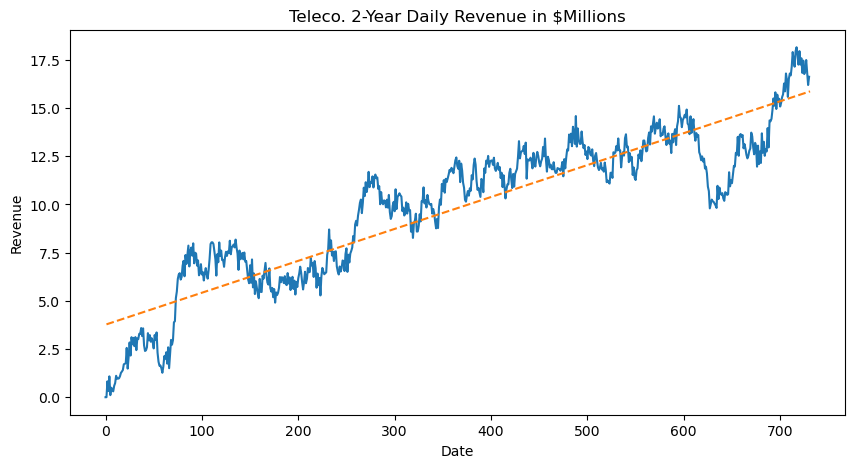

In [2]:
#visualizing the data from the dataframe as a line graph with trendline
plt.figure(figsize=(10,5))
plt.plot(df['Revenue'])
plt.xlabel("Date")
plt.ylabel("Revenue")
plt.title("Teleco. 2-Year Daily Revenue in $Millions")

#calculating and adding trendline to visualization (Bobbit, 2022)
z = np.polyfit(df["Day"], df["Revenue"], 1)
p = np.poly1d(z)
plt.plot(df["Day"], p(df["Day"]), linestyle = 'dashed')
plt.show()

### C2: Time Step Formatting
As it stands, the data above does not demonstrate x-data in dates, but rather as a day count. For this, we will want to change those numbers into dates spanning the two year period that this data was collected for. The information provided by WGU does not indicate specific dates or years for the data collected, so I will establish the starting year as 2022. This way the forecasted data will be for the 2024 period, a much more relevant date for shareholders to act upon. Before this dat conversion, I will check for any null data entries that may need to be removed.

In [3]:
df.isnull().value_counts()

Day    Revenue
False  False      731
dtype: int64

As there are no null values within my dataset, I can proceed to change the day column to dates ranging from 2022 to the beginning of 2024. The total range encompasses 2 years of revenue data.

In [4]:
#converting the day column to a time series object (Elleh, 2024)
df["Day"] = (pd.date_range(start = datetime(2022, 1, 1),
                          periods = 731, freq = 'D'))

#setting the index to the date
df.set_index("Day", inplace = True)

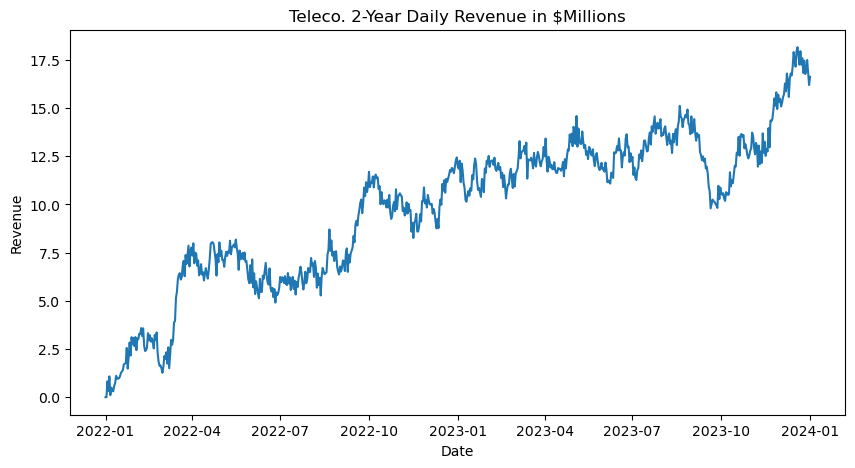

In [5]:
#visualizing the data from the dataframe as a line graph after date has been changed
plt.figure(figsize=(10,5))
plt.plot(df['Revenue'])
plt.xlabel("Date")
plt.ylabel("Revenue")
plt.title("Teleco. 2-Year Daily Revenue in $Millions")
plt.show()

### C3: Stationarity
The non-stationarity of the dataset is visually evident; from the time series chart above, we can see that the revenues of the teleco trend upwards, supported by the trendline demonstrated in C1. By the end of the two years, the daily revenue is substantially higher than when it began in 2022. As such, the data is visually not stationary due to its upwards trend, but  we could also perform a Dickey-Fuller Test to confirm this mathematically.

In [6]:
#using the adfuller function to determine the p-value and critical values
fullertest = adfuller(df['Revenue'])

print("The ADF statistical value is: " + str(fullertest[0]))
print("The p-value is: " + str(fullertest[1]))
print("The critical values are: " + str(fullertest[4]))

The ADF statistical value is: -1.924612157310183
The p-value is: 0.3205728150793967
The critical values are: {'1%': -3.4393520240470554, '5%': -2.8655128165959236, '10%': -2.5688855736949163}


The p-value is a measure of determination that can be used to assess the null-hypothesis of the augmented Dickey Fuller test. The null hypothesis for the ADF is that there is no statistical significance demonstrating stationarity within the data. As the p-value is above 0.05 the data does not show statistical significance for stationarity, meaning that we must accept the null hypothesis and the data is confirmed to be non-stationary.

### C4: Prepared Dataset Steps
1. Import data from csv file into dataframe
2. Utilize the .isnull() function to assess and identify any null values that need to be removed
3. Once no null values remain within the dataset, perform a conversion of the "Day" column to contain dates in Time Series format instead of isolated numbers, using January 1st of a year of choice for the start date.
4. Perform a visual analysis or utilize ADF function to assess the stationarity of the time series data
5. If data is non-stationary, perform differencing on the data to achieve stationarity, ensuring that the first entry is dropped due to now containing a null value
6. Check again with ADF for stationarity to confirm it is achieved.
7. Split the data into training and test sets, using a 80/20 train test split.

             Revenue
Day                 
2022-01-02  0.000793
2022-01-03  0.824749
2022-01-04 -0.505210
2022-01-05  0.762222
2022-01-06 -0.974900
...              ...
2023-12-28  0.170280
2023-12-29  0.559108
2023-12-30 -0.687028
2023-12-31 -0.608824
2024-01-01  0.425985

[730 rows x 1 columns]


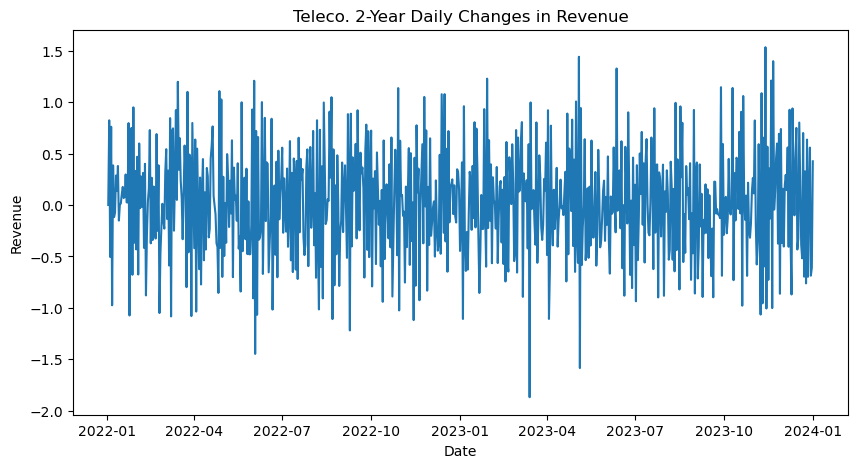

In [7]:
#differencing the dataset to induce stationarity
diff_df = df.diff().dropna()
print(diff_df)

#visualizing the data from the differenced dataframe as a line graph
plt.figure(figsize=(10,5))
plt.plot(diff_df['Revenue'])
plt.xlabel("Date")
plt.ylabel("Revenue")
plt.title("Teleco. 2-Year Daily Changes in Revenue")
plt.show()

In [8]:
#using the adfuller function to determine the p-value and critical values
diff_fuller = adfuller(diff_df['Revenue'])

print("The ADF statistical value is: " + str(diff_fuller[0]))
print("The p-value is: " + str(diff_fuller[1]))
print("The critical values are: " + str(diff_fuller[4]))

The ADF statistical value is: -44.87452719387599
The p-value is: 0.0
The critical values are: {'1%': -3.4393520240470554, '5%': -2.8655128165959236, '10%': -2.5688855736949163}


From the above ADF, we can see that the resulting p-value is statistically significant (less than 0.05). As such, we can reject the null hypothesis and state that the alternative hypothesis (that there is stationarity) is correct. Furthermore, the absolute critical values are less than the absolute ADF statistical value, supporting stationarity. 

In [9]:
#splitting original, not differenced data into training and testing sets with no shuffle and set state of 42
train, test = train_test_split(df['Revenue'], test_size=0.2, shuffle=False, random_state = 42)

print(train.head())
print(len(train), end='\n\n')
print(test.head())
print(len(test))

Day
2022-01-01    0.000000
2022-01-02    0.000793
2022-01-03    0.825542
2022-01-04    0.320332
2022-01-05    1.082554
Name: Revenue, dtype: float64
584

Day
2023-08-08    13.684826
2023-08-09    13.152903
2023-08-10    13.310290
2023-08-11    12.665601
2023-08-12    13.660658
Name: Revenue, dtype: float64
147


### C5: Prepared Dataset


In [10]:
#exporting stationary train and test datasets into csv files
train.to_csv('train_task1.csv')
test.to_csv('test_task1.csv')

### D1: Report Findings
Below I will be reporting the findings on the **differenced** dataset, as this step follows the preparation stage

**Seasonal Component (if any)**

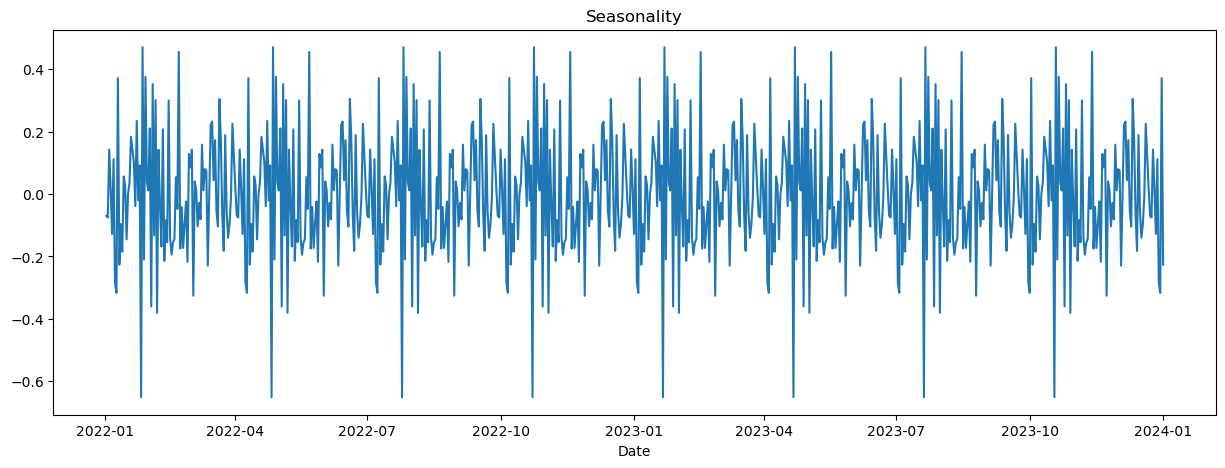

In [11]:
#plot seasonality
decomp_df = seasonal_decompose(diff_df['Revenue'], period = 90)
plt.figure(figsize=(15,5))
plt.plot(decomp_df.seasonal)
plt.xlabel("Date")
plt.title("Seasonality")
plt.show()

The above diagram demonstrates that there is a cyclical repetitive pattern in the daily changes in revenue, consistently repeating during the set period of 90 days.

**Trends**

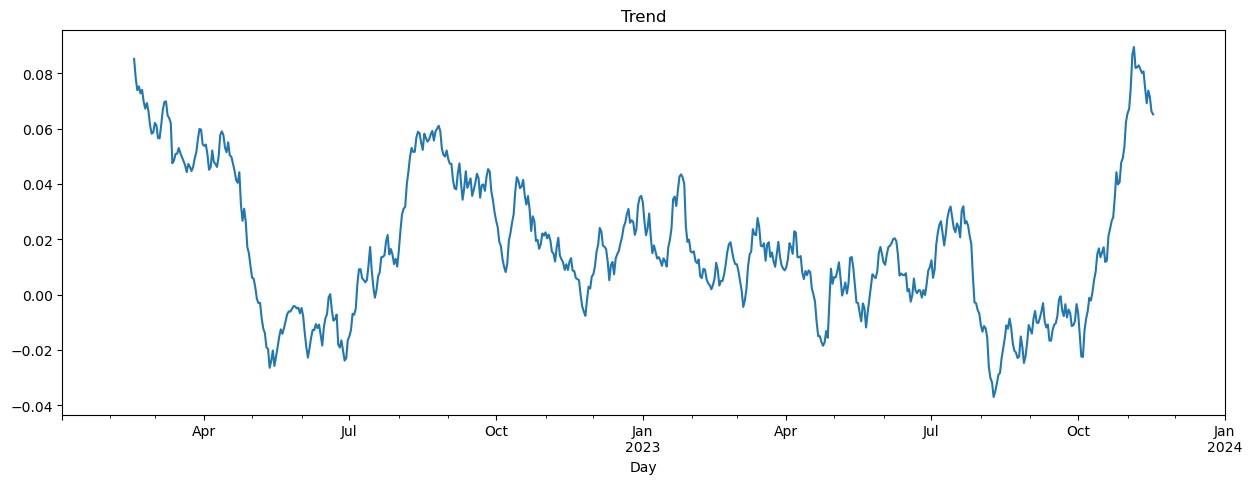

In [12]:
#plotting trend
plt.figure(figsize=(15,5))
decomp_df.trend.plot()
plt.title("Trend")
plt.show()

The graph demonstrates no trend applicable to the differenced dataset, which is good as it applies to the assumption of stationarity.

**Autocorrelation**

Text(0.5, 0, 'Lags')

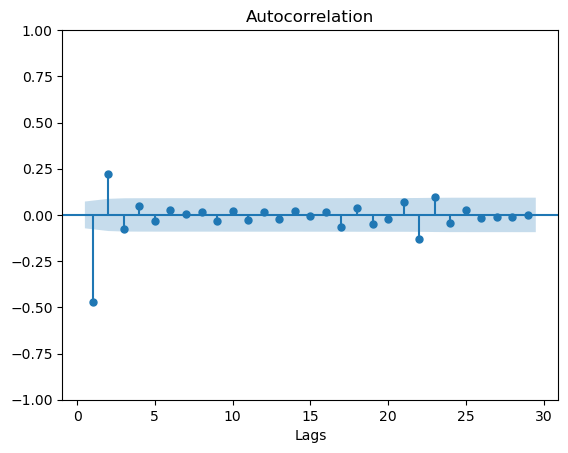

In [13]:
plot_acf(diff_df, zero = False);
plt.xlabel("Lags")

Text(0.5, 0, 'Lags')

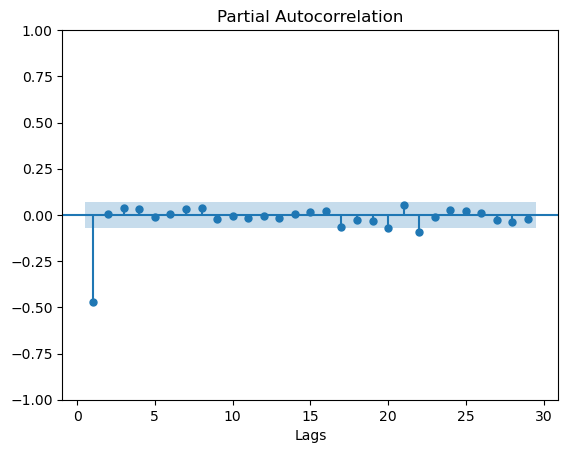

In [14]:
plot_pacf(diff_df, zero = False);
plt.xlabel("Lags")

We can also identify the ideal parameters of our ARIMA model through the use of auto_arima; a function that assesses varying levels of p, d, and q values to find the combination that results in the lowest AIC.

In [15]:
model1 = auto_arima(train, trace=True, seasonal = True, error_action='ignore', suppress_warnings=True)
model1.fit(train)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=776.988, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=910.148, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=773.046, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=798.905, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=909.276, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=775.043, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=775.043, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=776.811, Time=0.30 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=774.035, Time=0.04 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 0.950 seconds


ARIMA(order=(1, 1, 0), scoring_args={}, suppress_warnings=True)

Given the trailing nature of the ACF graph while the PACF graph cuts off after 1 lag, the model is most suited to be an AR(1) model. Furthermore, as the data parsed for the ARIMA model is non-stationary, a differential value of 1 is needed as well. Overall, the ideal ARIMA model parameters are (1,1,0). The additional seasonality parameters (P, D, Q, and m) seem to be irrelevant for the optimal model, which is why the second set of parameters is shown to be (0,0,0)[0].

**Spectral Density**

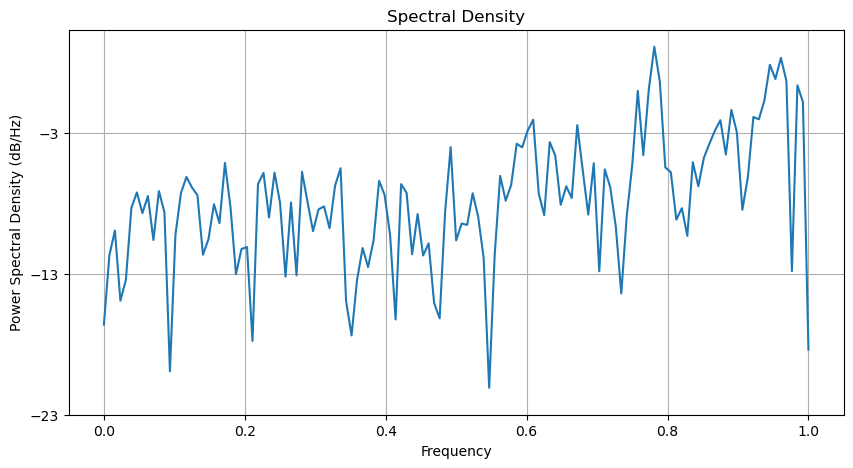

In [16]:
#plotting spectral density using matplotlib
plt.figure(figsize=(10,5))
plt.psd(x=diff_df["Revenue"])
plt.title("Spectral Density")
plt.show()

**Decomposed Time Series**

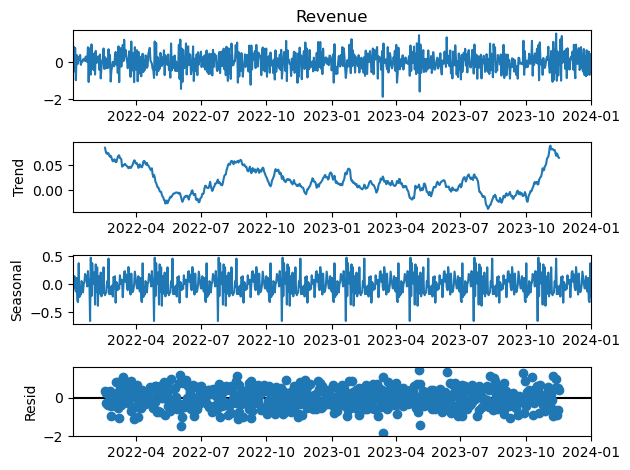

In [17]:
#plotting all decomposed time series information
decomp_df.plot();

**Confirming Lack of Residuals of Decomposed Series**

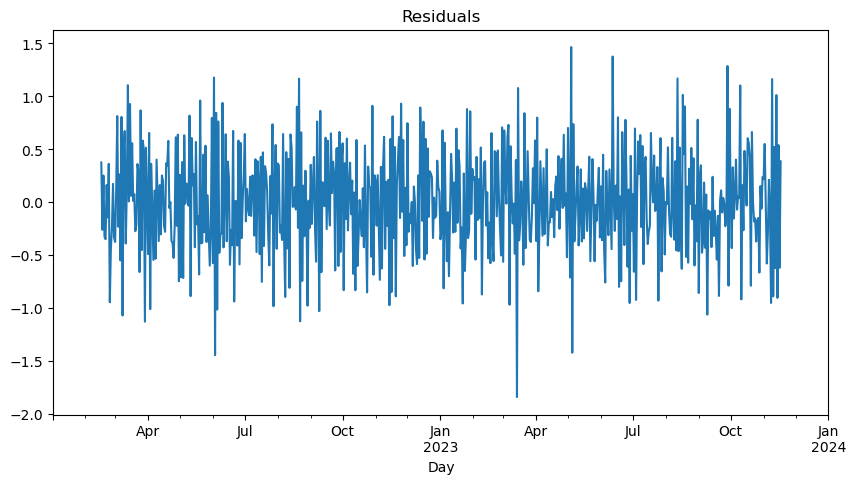

In [18]:
#plotting residuals of decomposed time series
plt.figure(figsize=(10,5))
plt.title("Residuals")
decomp_df.resid.plot()
plt.show()

The graph above does not seem to demonstrate any trends within the residuals of the decomposed time series

### D2: ARIMA Model
From the analysis performed in D1, the partial autocorrelation chart indicated that the most suitable model for ARIMA forecasting is an AR(1) model. As such, when considering the p, d, and q values of our ARIMA model, the parameters would be (1, 1, 0). The below model is ideal for application in forecasting for the proposed research question and is appropriate for the **original** dataset, as the stationary dataset used to evaluate the appropriate model is a representation of daily change in revenues which we are not aiming to forecast.

In [19]:
#removing 'No frequency information was provided' error
import warnings
warnings.filterwarnings('ignore')

#fitting the model (Fulton, n.d.)
model = ARIMA(train, order = (1,1,0), seasonal_order = (0,0,0,0), freq = 'D')
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                Revenue   No. Observations:                  584
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -385.018
Date:                Wed, 12 Jun 2024   AIC                            774.035
Time:                        10:21:33   BIC                            782.772
Sample:                    01-01-2022   HQIC                           777.441
                         - 08-07-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4578      0.036    -12.618      0.000      -0.529      -0.387
sigma2         0.2193      0.014     15.954      0.000       0.192       0.246
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 1.81
Prob(Q):                              0.91   Prob(JB):                         0.40
Heteroskedasticity (H):               0.97   Skew:                            -0.07
Prob(H) (two-sided):                  0.81   Kurtosis:                         2.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### D3: Forecasting with ARIMA Model


In [20]:
print(test.shape)

(147,)


In [21]:
#establish forecast (Elleh, 2024)
forecast = results.get_forecast(steps=147)

#getting confidence values for prediction
confidence_intervals = forecast.conf_int()

#getting confidence intervals 
lower_lim = confidence_intervals.loc[:, 'lower Revenue']
upper_lim = confidence_intervals.loc[:, 'upper Revenue']

#printing predicted revenue values
forecast.predicted_mean

2023-08-08    13.311586
2023-08-09    13.400077
2023-08-10    13.359566
2023-08-11    13.378112
2023-08-12    13.369622
                ...    
2023-12-28    13.372288
2023-12-29    13.372288
2023-12-30    13.372288
2023-12-31    13.372288
2024-01-01    13.372288
Freq: D, Name: predicted_mean, Length: 147, dtype: float64

In [22]:
print(confidence_intervals)

            lower Revenue  upper Revenue
2023-08-08      12.393824      14.229347
2023-08-09      12.356091      14.444064
2023-08-10      12.108188      14.610945
2023-08-11      11.989503      14.766721
2023-08-12      11.839696      14.899548
...                   ...            ...
2023-12-28       5.820428      20.924148
2023-12-29       5.794232      20.950344
2023-12-30       5.768127      20.976449
2023-12-31       5.742111      21.002465
2024-01-01       5.716183      21.028393

[147 rows x 2 columns]


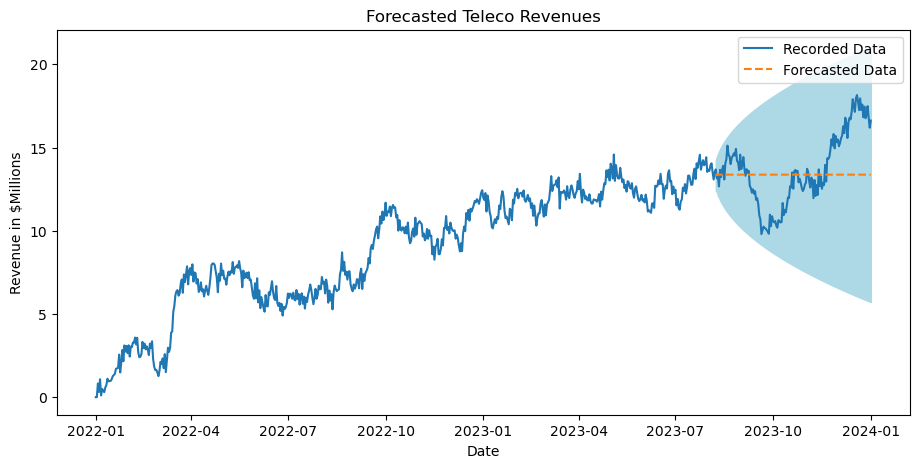

In [23]:
#plotting the original time series data (Elleh, 2024)
plt.figure(figsize = (11,5))
plt.plot(df.index, df, label='Recorded Data')

#plotting the forecasted revenues against recorded end of 2023
plt.plot(forecast.predicted_mean, label='Forecasted Data', linestyle='dashed')
plt.title("Forecasted Teleco Revenues")
plt.ylabel("Revenue in $Millions")
plt.xlabel("Date")
plt.legend()

#shading the confidence intervals
plt.fill_between(lower_lim.index, lower_lim, upper_lim, color='lightblue')
plt.show()

### D4: Output
In addition to the stationarity validation, autocorrelation, mean and confidence interval, as well as forecasting performed above, calculations for root mean squared error of the forecasted data as well as diagnostics charts can be found below:

In [24]:
#calculating root mean squared error
rmse = mean_squared_error(df["Revenue"].iloc[-147:], forecast.predicted_mean, squared=False)
print("The root mean squared error is: " + str(rmse))

The root mean squared error is: 2.176506685113189


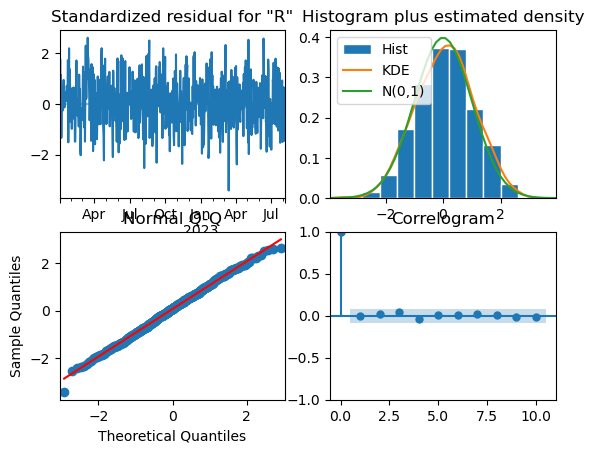

In [25]:
#visualizing diagnostic information
results.plot_diagnostics();

### D5: Code


All code utilized for analyis can be found above.

### E1: Results
**Selection of ARIMA Model**

My ARIMA model was selected on the basis of the ACF/PACF visualizations presented in Section D1. The partial autocorrelation cutting off after 1 indicated that my P value should be 1 (AR(1)), while the ACF trailed off past 2, meaning that my q value would be 0. Additionally, as the original dataset was determined to be non-stationary through my ADF calculation, the series needed to be differenced to be utilized appropriately for my model. As such, I used a 'd' parameter of 1. The information above was further supported by performing an auto-arima function, which identified the parameters that would yield the lowest AIC to be (1,1,0).

**Prediction Interval of Forecast & Justification of Forecast Length**

The prediction interval for my forecasted datapoints is 147 days. The reason this value was chosen was because it accounts for the length of my testing data (20% of the total data available). In comparison, the testing data available accounts for 584, just shy of 20 months of data for my model to train on. Overall, the split utilized for training and testing data is standard, but given that the data appears to begin with the company starting from 0 revenue and tracks its first two years of growth, it was necessary to keep the testing data count down to a minimum as there is not a broad historical revenue record to analyze.

**Model Evaluation**

Evaluation of the model was primarily done in Section D4. The root mean squared error (rsme) of my predicted is indicative of my datapoints' average magnitude of distance away from the mean. As such, a lower number represents a tighter spread of data and better accuracy in my model's forecast. In evaluating my model's forecasting accuracy, the rsme calculated was approximately 2.18, which is a very low number, statistically confirming my model demonstrates the appropriate capability for forecasting revenues.

Taking into account the diagnostic information from section D4, the residuals of the data demonstrate further that the model is appropriate in assessing my research question. We can see that the residuals (how far our predictions from the real values), is relatively small, hovering around the 1-2 unit range. The residuals also follow a normal distribution as can be seen from the neighboring histogram, and the Normal Q-Q plot. Finally, the correlogram notes that there is no significant correlation for any lags above 0 that would skew the model (Fulton, n.d).

### E2: Annotated Visualization


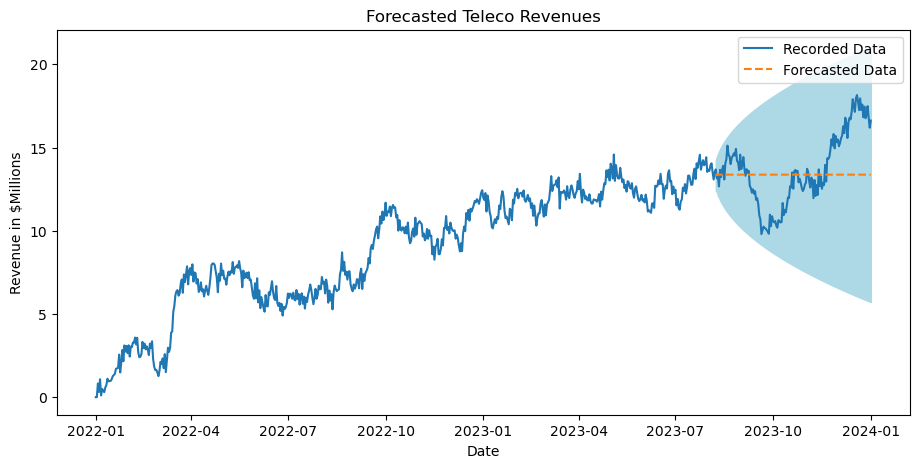

In [26]:
#plotting the original time series data (Elleh, 2024)
plt.figure(figsize = (11,5))
plt.plot(df, label='Recorded Data')

#plotting the forecasted revenues against recorded end of 2023
plt.plot(forecast.predicted_mean, label='Forecasted Data', linestyle='dashed')
plt.title("Forecasted Teleco Revenues")
plt.ylabel("Revenue in $Millions")
plt.xlabel("Date")
plt.legend()

#shading the confidence intervals
plt.fill_between(lower_lim.index, lower_lim, upper_lim, color='lightblue')
plt.show()

When compared against the test portion of the time series data, we can see that the forecast falls directly within the center of the recorded revenue data for the final 147 days of the 2-year measurement period. While it appears to be flat and does not lend towards an upward or downwards trend in the company's forecasted revenue, the predicted means calculated in Section D3 indicate that the forecasted change in revenue is not 0, just very small. Despite this, the forecast (and to a better extent the confidence intervals) fit quite well against the recorded testing portion of the Teleco revenue. We see that the *actual* recorded portion fluctuates in a manner that does not indicate a likely resulting trend, starting off with a large contraction, then climbing upwards near the end of 2023.

What we can also identify is that the confidence intervals of the forecast (the blue shaded portion) encapsulates the variety of ranges that the revenue will approach. As such, this range of intervals presents the minimum and maximum ranges that the forecasted revenue could end up being. Overall, the expectation based on this forecast is that the company is expected to have a relatively flat year for 2024.

### E3: Recommendation
As stated above, the forecast of the revenue for the Teleco company indicates that the company may possibly approaching a 'cap' in customer influx, this could be due to the company becoming mature in a saturated environment, it is also possible there aren't more attractive marketing benefits being provided to attract new clients, or perhaps the daily revenue is expected to fluctuate up and down around the forecasted line. Nonetheless despite the potential plateau, the confidence intervals demonstrate the potential for daily revenues to climb higher than it has before, even if just for a short period. Static revenue is not necessarily a problem either; the information presented is for *daily* revenue, and having a consistent daily revenue stream is paramount to stable growth and re-investment. 

This information should be passed to internal stakeholders to make them aware of the plateau period. This way they can build a budget that suits a consistent revenue inflow. Furthermore, this period can be utilized to strengthen existing relationships with customers to strengthen retention before focusing on expansion and further growth.

### G: Code Sources
Elleh, Festus. January 1, 2024. *Data Preprocessing Python*. Western Governors University. https://wgu.hosted.panopto.com/Panopto/Pages/Viewer.aspx?id=8d32afc8-d66f-42d5-9117-b100016cf9ac

Elleh, Festus. n.d. *Building ARIMA Model in Python*. Western Governors University. https://wgu.hosted.panopto.com/Panopto/Pages/Viewer.aspx?id=1aaf2389-6483-4000-b498-b14f00441d57

Bobbit, Zach. March 31, 2022. *How to Add a Trendline in Matplotlib*. Statology. https://www.statology.org/matplotlib-trendline/

Fulton, James. n.d. *ARIMA Models In Python*. Datacamp. https://campus.datacamp.com/courses/arima-models-in-python/fitting-the-future?ex=1

### H: Sources
Dash, Shailey. March 7, 2020. *An Overview of Time Series Forecasting Models Part 1: Classical Time Series Forecasting Models*. Medium. https://medium.com/@shaileydash/an-overview-of-time-series-forecasting-models-part-1-classical-time-series-forecasting-models-2d877de76e0f

Fulton, James. n.d. ARIMA Models In Python. Datacamp. https://campus.datacamp.com/courses/arima-models-in-python/fitting-the-future?ex=1